# Packages

In [1]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow and keras
from keras.utils.vis_utils import plot_model

import tensorflow.keras.layers as L
import keras.backend as K
import tensorflow as tf

In [2]:
!pip install spektral -q

In [3]:
from spektral.layers import GraphConv

# Read Data

In [4]:
train_json_path = "/kaggle/input/stanford-covid-vaccine/train.json"
test_json_path = "/kaggle/input/stanford-covid-vaccine/test.json"
sample_sub_path = "/kaggle/input/stanford-covid-vaccine/sample_submission.csv"

output_path = "./"
bpps_path = "/kaggle/input/stanford-covid-vaccine/bpps"

train_df = pd.read_json(train_json_path, lines=True)
test_df = pd.read_json(test_json_path, lines=True)

# there are 2 part of the test set, they have different seq length
public_df = test_df.query("seq_length == 107").copy()
private_df = test_df.query("seq_length == 130").copy()

In [5]:
train_df.shape

(2400, 19)

# Prediction Columns

In [6]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
train_df[pred_cols].head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,"[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,"[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,"[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [7]:
train_y = np.array(train_df[pred_cols].values.tolist()).transpose((0, 2, 1))
train_y.shape

(2400, 68, 5)

# Sequence Features

Each mRNA contains 107 bases in train:

In [8]:
train_df[["id", "sequence", "structure", "predicted_loop_type"]].head()

,id,sequence,structure,predicted_loop_type
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...


Both `sequence`, `structure` and `predicted_loop_type` are sequences data for those 107 bases, let's transform them. 

(2400, 3) -> (2400, 107, 3)

In [9]:
# label encodings for 
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
sequence_token2int = {x:i for i, x in enumerate('AGUC')}
structure_token2int = {
    '.': 0,
    '(': 1,
    ')': 2,
}
loop_token2int = {x:i for i, x in enumerate('SMIBHEX')}
token2int_map = {
    "sequence": sequence_token2int,
    "structure": structure_token2int,
    "predicted_loop_type": loop_token2int
}
sequence_columns = ["sequence", "structure", "predicted_loop_type"]

def to_seq(df):
    return np.transpose(
        np.array(
            df[sequence_columns]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

train = to_seq(train_df)
public = to_seq(public_df)
private = to_seq(private_df)

train.shape, public.shape, private.shape

((2400, 107, 3), (629, 107, 3), (3005, 130, 3))

Now let's apply one-hot encoding to the data

(2400, 107, 3) -> (2400, 107, 14)

In [10]:
def to_one_hot(df):
    temp = np.transpose(
        np.array([
            df[col]
            .apply(lambda seq: [token2int_map[col][x] for x in seq])
            .values
            .tolist()
            for col in sequence_columns
        ]),
        (1, 2, 0)
    )
    ohe_1 = tf.keras.utils.to_categorical(temp[:,:,0], 4)
    ohe_2 = tf.keras.utils.to_categorical(temp[:,:,1], 3)
    ohe_3 = tf.keras.utils.to_categorical(temp[:,:,2], 7)
    return np.concatenate([ohe_1, ohe_2, ohe_3], axis=2)

train_ohe = to_one_hot(train_df)
public_ohe = to_one_hot(public_df)
private_ohe = to_one_hot(private_df)

train_ohe.shape, public_ohe.shape, private_ohe.shape

((2400, 107, 14), (629, 107, 14), (3005, 130, 14))

# Pair/Connectivity Features

Get the adjacency matrices from the structure sequence:

In [11]:
def get_adjacency_matrix(inps):
    As = []
    for row in range(0, inps.shape[0]):
        A = np.zeros((inps.shape[1], inps.shape[1]))
        stack = []
        opened_so_far = []

        for seqpos in range(0, inps.shape[1]):
            # A[seqpos, seqpos] = 1
            if inps[row, seqpos, 1] == 0:
                stack.append(seqpos)
                opened_so_far.append(seqpos)
            elif inps[row, seqpos, 1] == 1:
                openpos = stack.pop()
                A[openpos, seqpos] = 1
                A[seqpos, openpos] = 1
        As.append(A)
    return np.array(As)

train_adj = get_adjacency_matrix(train)
public_adj = get_adjacency_matrix(public)
private_adj = get_adjacency_matrix(private)

train_adj.shape, public_adj.shape, private_adj.shape

((2400, 107, 107), (629, 107, 107), (3005, 130, 130))

In [12]:
train_adj.mean(), public_adj.mean(), private_adj.mean()

(0.0041319474772178065, 0.004322480243829655, 0.0038859494530811564)

Get the base pair probabilities from the given bpps files

In [13]:
def get_bpps(mRNA_ids):
    bpps = []
    for mRNA_id in tqdm(mRNA_ids):
        bpps.append(
            np.load(f"{bpps_path}/{mRNA_id}.npy"),
        )
    return np.array(bpps)


train_bpps = get_bpps(train_df.id.values)
public_bpps = get_bpps(public_df.id.values)
private_bpps = get_bpps(private_df.id.values)

train_bpps.shape, public_bpps.shape, private_bpps.shape 

100%|██████████| 3005/3005 [00:09<00:00, 326.04it/s]


((2400, 107, 107), (629, 107, 107), (3005, 130, 130))

In [14]:
train_bpps.mean(), public_bpps.mean(), private_bpps.mean() 

(0.003936093904915271, 0.0037162253979562986, 0.004133111640768379)

# Get pair probabilities statistics for each base

In [15]:
train_bpps_stats = [train_bpps.mean(axis=2), train_bpps.max(axis=2)]
public_bpps_stats = [public_bpps.mean(axis=2), public_bpps.max(axis=2)]
private_bpps_stats = [private_bpps.mean(axis=2), private_bpps.max(axis=2)]

In [16]:
train_bpps_stats = np.concatenate([stats[:,:,None] for stats in train_bpps_stats], axis=2)
public_bpps_stats = np.concatenate([stats[:,:,None] for stats in public_bpps_stats], axis=2)
private_bpps_stats = np.concatenate([stats[:,:,None] for stats in private_bpps_stats], axis=2)

train_bpps_stats.shape, public_bpps_stats.shape, private_bpps_stats.shape

((2400, 107, 2), (629, 107, 2), (3005, 130, 2))

# Model

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F690886%2F83da03ea10245b6867febd170f6188f4%2FScreenshot%202020-10-08%20at%207.51.09%20AM.png?generation=1602114976893373&alt=media)

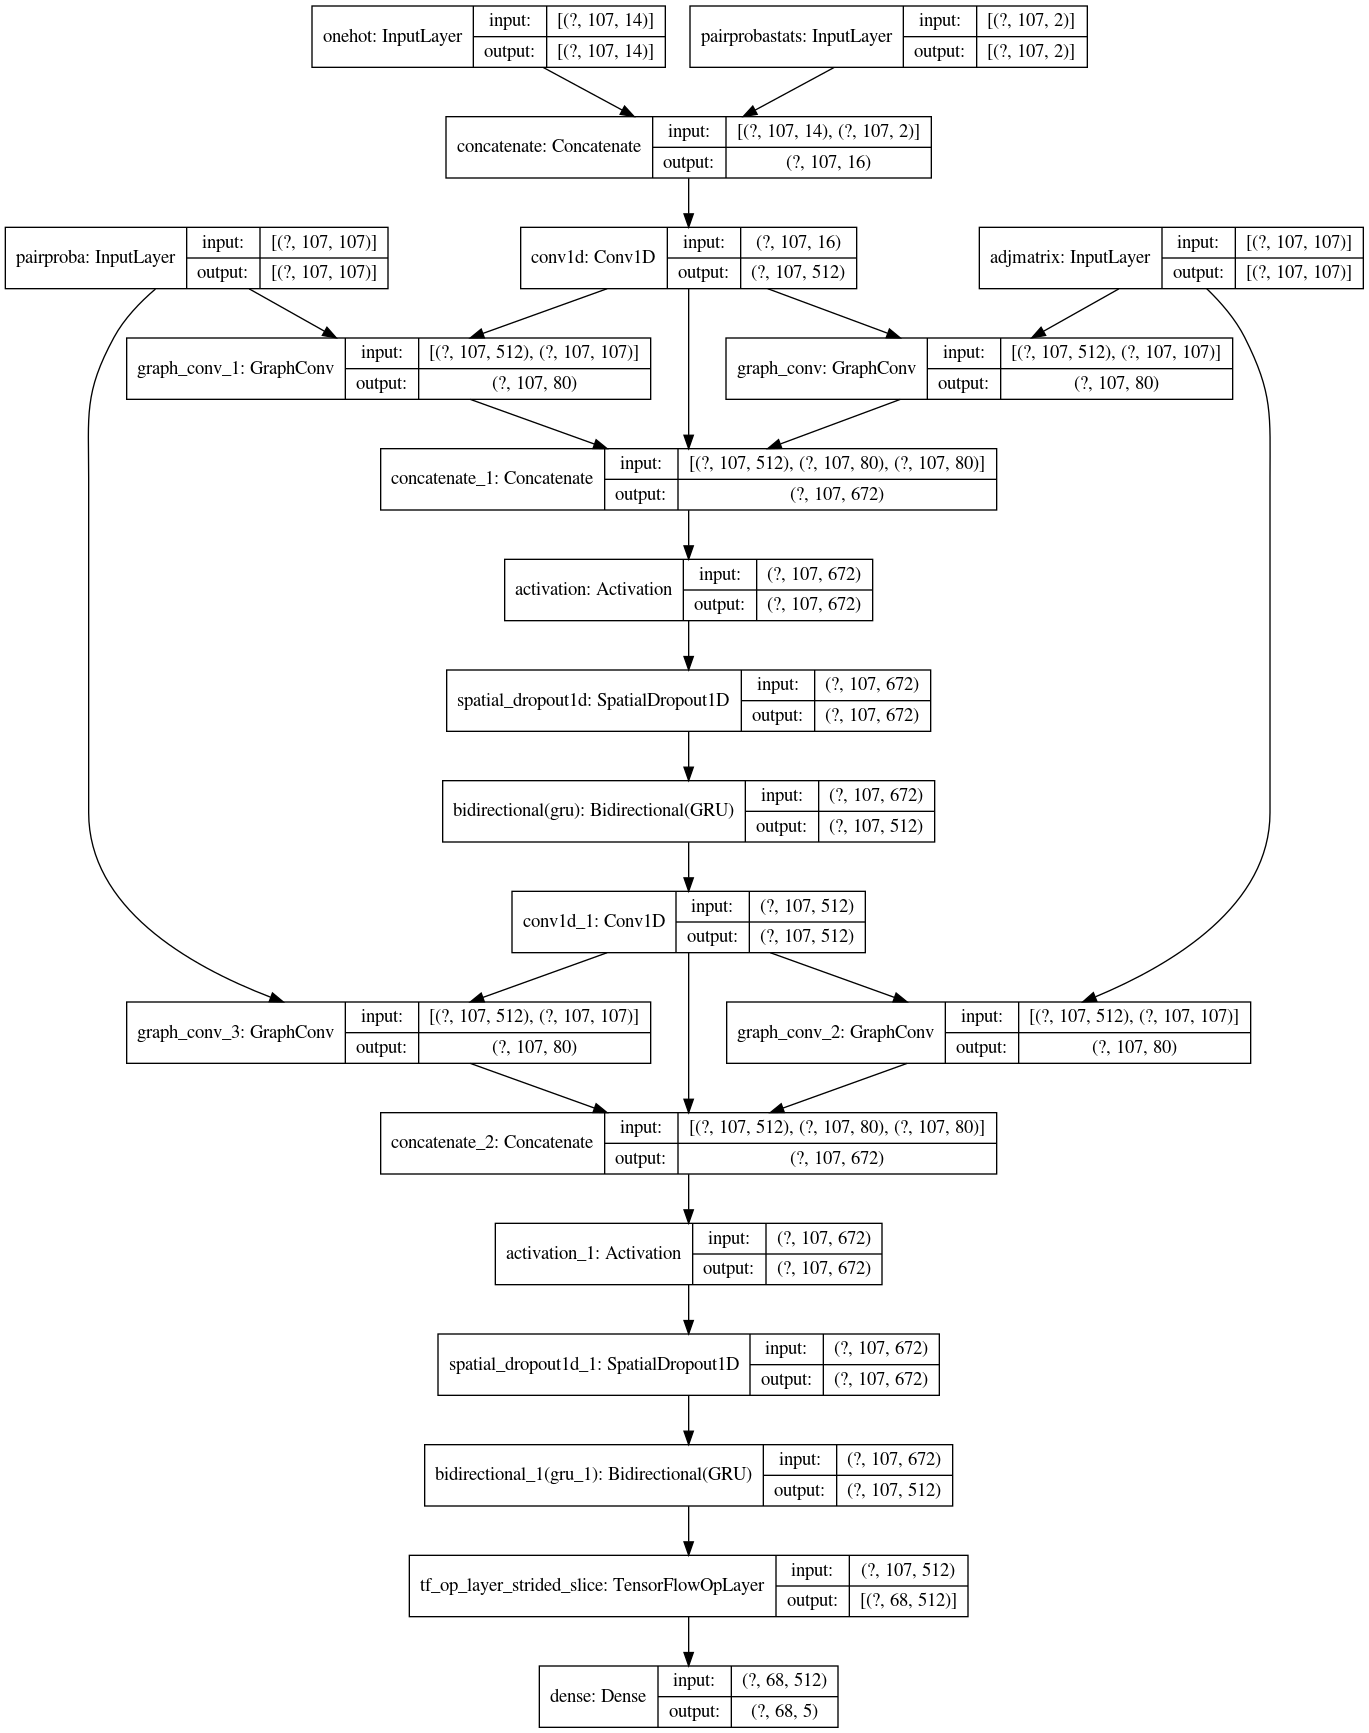

In [17]:
scored_seq_length = 68

# loss functions
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred):
    score = 0
    for i in range(y_actual.shape[2]):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / y_actual.shape[2]
    return score
    

def build_model(input_seq_len=107, output_seq_len=scored_seq_length):
    
    def _bi_gru_block(x, hidden_dim, dropout):
        gru = L.Bidirectional(
            L.GRU(hidden_dim, 
                  dropout=dropout,
                  return_sequences=True,
                 ),
        )(x)
        return gru

    def _conv_block(x, adj_m, bpp_m, conv_filters, graph_channels):
        # local 1-D convolution
        conv = L.Conv1D(
            conv_filters, 5,
            padding='same',
            activation='tanh',
        )(x)
        
        # graph convolution
        gcn_1 = GraphConv(
            graph_channels,
            activation='tanh',
        )([conv, adj_m])
        
        gcn_2 = GraphConv(
            graph_channels,
            activation='tanh',
        )([conv, bpp_m])

        conv = L.Concatenate()([conv, gcn_1, gcn_2])
        conv = L.Activation("relu")(conv)
        conv = L.SpatialDropout1D(0.1)(conv)
        
        return conv
    
    # inputs
    one_hot_encoding_inputs = L.Input(shape=(input_seq_len, 14), name="onehot")
    # adjacency matrix about seq. connectivity
    adj_matrix_inputs = L.Input((input_seq_len, input_seq_len), name="adjmatrix")
    # base pair proba
    base_pair_proba_inputs = L.Input((input_seq_len, input_seq_len), name="pairproba")
    # base pair proba stats
    base_pair_proba_stats_inputs = L.Input(shape=(input_seq_len, 2), name="pairprobastats")
    
    merged_inputs = L.Concatenate()([one_hot_encoding_inputs, base_pair_proba_stats_inputs])
    
    # convolution and recurrent blocks.
    hidden = _conv_block(merged_inputs, adj_matrix_inputs, base_pair_proba_inputs, 512, 80)
    hidden = _bi_gru_block(hidden, 256, 0.5)
    hidden = _conv_block(hidden, adj_matrix_inputs, base_pair_proba_inputs, 512, 80)
    hidden = _bi_gru_block(hidden, 256, 0.5)
    
    out = hidden[:, :output_seq_len]
    out = L.Dense(5, activation='linear')(out)
    
    model = tf.keras.Model(
        inputs=[
            one_hot_encoding_inputs,
            adj_matrix_inputs,
            base_pair_proba_inputs,
            base_pair_proba_stats_inputs,
        ],
        outputs=out,
    )

    return model

model = build_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [18]:
split_results  = train_test_split(
    train_ohe,
    train_adj,
    train_bpps,
    train_bpps_stats,
    train_y,
    train_df.signal_to_noise,
    train_df.SN_filter,
    test_size=0.1,
    random_state=42,
)

[a.shape for a in split_results]

[(2160, 107, 14),
 (240, 107, 14),
 (2160, 107, 107),
 (240, 107, 107),
 (2160, 107, 107),
 (240, 107, 107),
 (2160, 107, 2),
 (240, 107, 2),
 (2160, 68, 5),
 (240, 68, 5),
 (2160,),
 (240,),
 (2160,),
 (240,)]

In [19]:
trn_ohe, val_ohe, trn_adj, val_adj, trn_bpps, val_bpps, trn_bpps_stats, val_bpps_stats, trn_y, val_y, trn_snr, val_snr, trn_snf, val_snf = split_results

In [20]:
model = build_model()
model.compile(tf.keras.optimizers.Adam(), loss=mcrmse)

In [21]:
trn_inputs = [trn_ohe, trn_adj, trn_bpps, trn_bpps_stats]
val_inputs = [val_ohe, val_adj, val_bpps, val_bpps_stats]

In [22]:
# only validate on data with sn_filter = 1
val_mask = np.where((val_snf==1))
val_inputs = [val_input[val_mask] for val_input in val_inputs]
val_y = val_y[val_mask]

In [23]:
sample_weight = np.log(trn_snr+1.11)/2

In [24]:
history = model.fit(
    trn_inputs, trn_y,
    validation_data = (val_inputs, val_y),
    batch_size=64,
    epochs=300,
    sample_weight=sample_weight,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(verbose=1, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint(f'model.h5',save_best_only=True, verbose=0, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(
            patience=20, 
            monitor='val_loss',
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        ),
    ],
    verbose=2
)
print(f"Min validation loss history={min(history.history['val_loss'])}")

Epoch 1/300
34/34 - 5s - loss: 0.3642 - val_loss: 0.3536
Epoch 2/300
34/34 - 3s - loss: 0.2819 - val_loss: 0.3102
Epoch 3/300
34/34 - 3s - loss: 0.2584 - val_loss: 0.2873
Epoch 4/300
34/34 - 3s - loss: 0.2468 - val_loss: 0.2689
Epoch 5/300
34/34 - 3s - loss: 0.2388 - val_loss: 0.2581
Epoch 6/300
34/34 - 3s - loss: 0.2319 - val_loss: 0.2500
Epoch 7/300
34/34 - 3s - loss: 0.2255 - val_loss: 0.2458
Epoch 8/300
34/34 - 3s - loss: 0.2210 - val_loss: 0.2435
Epoch 9/300
34/34 - 3s - loss: 0.2170 - val_loss: 0.2414
Epoch 10/300
34/34 - 3s - loss: 0.2147 - val_loss: 0.2392
Epoch 11/300
34/34 - 3s - loss: 0.2106 - val_loss: 0.2391
Epoch 12/300
34/34 - 3s - loss: 0.2086 - val_loss: 0.2340
Epoch 13/300
34/34 - 3s - loss: 0.2056 - val_loss: 0.2326
Epoch 14/300
34/34 - 3s - loss: 0.2033 - val_loss: 0.2308
Epoch 15/300
34/34 - 3s - loss: 0.2030 - val_loss: 0.2306
Epoch 16/300
34/34 - 3s - loss: 0.2005 - val_loss: 0.2282
Epoch 17/300
34/34 - 3s - loss: 0.1978 - val_loss: 0.2265
Epoch 18/300
34/34 - 3s

In [25]:
model.load_weights(f'model.h5')

In [26]:
val_preds = model.predict(val_inputs)
tf.reduce_mean(mcrmse(val_y, val_preds))

<tf.Tensor: shape=(), dtype=float32, numpy=0.19283596>

# Prepare submission

In [27]:
model_public = build_model(107, 107)
model_private = build_model(130, 130)

model_public.load_weights(f'model.h5')
model_private.load_weights(f'model.h5')

In [28]:
public_inputs = [public_ohe, public_adj, public_bpps, public_bpps_stats,]
private_inputs = [private_ohe, private_adj, private_bpps, private_bpps_stats,]

In [29]:
test_preds = [model_public.predict(public_inputs), model_private.predict(private_inputs)]
test_dfs = [public_df, private_df]

test_preds[0].shape, test_preds[1].shape

((629, 107, 5), (3005, 130, 5))

In [30]:
preds_ls = []
for df, preds in zip(test_dfs, test_preds):
    for i, uid in tqdm(enumerate(df.id)):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        preds_ls.append(single_df)
preds_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()

test_df.shape, preds_df.shape

629it [00:01, 574.85it/s] 
3005it [00:02, 1106.20it/s]


((3634, 7), (457953, 6))

In [31]:
submission = preds_df[['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
submission.to_csv(f'submission.csv', index=False)
print(f'wrote to submission.csv')

wrote to submission.csv


In [32]:
submission.shape, pd.read_csv(sample_sub_path).shape, test_df.shape

((457953, 6), (457953, 6), (3634, 7))